# Generate Mock Data

In this example we generate mock data with a variety of systematic effects including photometric redshifts, source galaxy distributions, and shape noise.  We then populate a galaxy cluster object

In [1]:
import sys
sys.path.append('./support')
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Make sure we know which version we're using

In [2]:
clmm.__version__

'0.1.0'

### Import mock data module and setup the configuration 

In [3]:
import mock_data as mock

Mock data generation requires a defined cosmology

In [4]:
from astropy.cosmology import FlatLambdaCDM
mock_cosmo = FlatLambdaCDM(H0=70, Om0=0.27, Ob0=0.045)

Mock data generation requires some cluster information

In [5]:
cosmo = mock_cosmo
cluster_id = "Awesome_cluster"
cluster_m = 1.e15
cluster_z = 0.3
src_z = 0.8
concentration = 4
ngals = 1000 # number of source galaxies
Delta = 200 # mass definition with respect to critical overdensity
cluster_ra = 0.0
cluster_dec = 0.0


### Generate the mock catalog with different options

Clean data: no noise, all galaxies at the same redshift

In [6]:
zsrc_min=cluster_z+0.1

In [7]:
ideal_data = mock.generate_galaxy_catalog(
    cluster_m, cluster_z, concentration, cosmo, ngals, Delta, src_z, zsrc_min=zsrc_min)

Noisy data: shape noise, all galaxies at the same redshift

In [8]:
noisy_data_src_z = mock.generate_galaxy_catalog(
    cluster_m, cluster_z, concentration, cosmo, ngals, Delta, src_z, zsrc_min=zsrc_min,
    shapenoise=0.05)

Noisy data: photo-z errors (and pdfs!), all galaxies at the same redshift

In [9]:
noisy_data_photoz = mock.generate_galaxy_catalog(
    cluster_m, cluster_z, concentration, cosmo, ngals, Delta, src_z, zsrc_min=zsrc_min,
    shapenoise=0.05, photoz_sigma_unscaled=0.05)

Clean data: source galaxy redshifts drawn from Chang et al. 2013

In [10]:
ideal_with_src_dist = mock.generate_galaxy_catalog(
    cluster_m, cluster_z, concentration, cosmo, ngals, Delta, 'chang13', zsrc_min=zsrc_min,
    zsrc_max=7.0)


Noisy data: galaxies following redshift distribution, redshift error, shape noise

In [11]:
allsystematics = mock.generate_galaxy_catalog(
    cluster_m, cluster_z, concentration, cosmo, ngals, Delta, 'chang13', zsrc_min=zsrc_min,
    zsrc_max=7.0, shapenoise=0.005, photoz_sigma_unscaled=0.05)

Sanity check: checking that no galaxies where drawn below zsrc_min

In [12]:
print('Number of galaxies below zsrc_min:')
print('ideal_data:',np.sum(ideal_data['z']<zsrc_min))
print('noisy_data_src_z:',np.sum(noisy_data_src_z['z']<zsrc_min))
print('noisy_data_photoz:',np.sum(noisy_data_photoz['z']<zsrc_min))
print('ideal_with_src_dist:',np.sum(ideal_with_src_dist['z']<zsrc_min))
print('allsystematics:',np.sum(allsystematics['z']<zsrc_min))

Number of galaxies below zsrc_min:
ideal_data: 0
noisy_data_src_z: 0
noisy_data_photoz: 0
ideal_with_src_dist: 0
allsystematics: 0


### Inspect the catalog data

Ideal catalog first entries: no noise on the shape measurement, all galaxies at z=0.8

In [19]:
for n in ideal_data.colnames: ideal_data[n].format = "%6.3e"
ideal_data[0:3].pprint()

    ra        dec        e1         e2         z         id   
---------- --------- ---------- ---------- --------- ---------
 5.692e-02 1.757e-01  1.200e-02  8.687e-03 8.000e-01 0.000e+00
-2.700e-01 1.132e-01 -5.870e-03 -5.968e-03 8.000e-01 1.000e+00
-2.788e-02 1.074e-01  2.248e-02 -1.251e-02 8.000e-01 2.000e+00


With photo-z errors

In [23]:
for n in noisy_data_photoz.colnames: noisy_data_photoz[n].format = "%6.3e"
noisy_data_photoz[0:3].pprint()

    ra        dec         e1     ...       pzpdf [34]           id   
---------- ---------- ---------- ... ---------------------- ---------
-2.722e-01 -2.372e-01 -1.113e-02 ... 8.802e-07 .. 1.622e-06 0.000e+00
-2.030e-01  8.921e-02 -2.554e-02 ... 8.802e-07 .. 1.622e-06 1.000e+00
-2.246e-01  1.648e-01  3.264e-02 ... 8.802e-07 .. 1.622e-06 2.000e+00


Text(0.5,0,'Source Redshift')

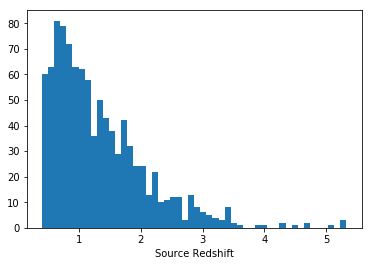

In [15]:
# Histogram of the redshift distribution of bkg galaxies (starting at z_cluster + 0.1)
hist = plt.hist(allsystematics['z'], bins=50)
plt.xlabel('Source Redshift')

Text(0,0.5,'Photo-z Probability Distribution')

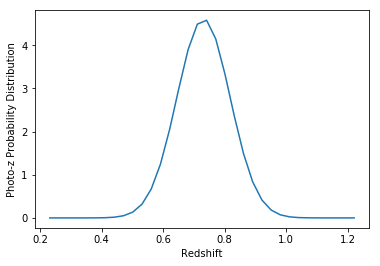

In [16]:
# pdz for the first galaxy in the catalog
plt.plot(allsystematics['pzbins'][0], allsystematics['pzpdf'][0])
plt.xlabel('Redshift')
plt.ylabel('Photo-z Probability Distribution')

Populate in a galaxy cluster object

In [17]:
# At the moment mock data only allow for a cluster centred on (0,0)
cluster_ra = 0.0
cluster_dec = 0.0
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec, 
                               cluster_z, allsystematics)

Plot source galaxy ellipticities

Text(0,0.5,'Ellipticity 2')

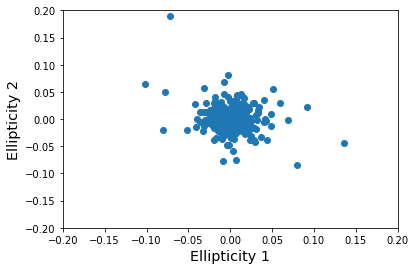

In [18]:
plt.scatter(gc_object.galcat['e1'],gc_object.galcat['e2'])

plt.xlim(-0.2, 0.2)
plt.ylim(-0.2, 0.2)
plt.xlabel('Ellipticity 1',fontsize='x-large')
plt.ylabel('Ellipticity 2',fontsize='x-large')